Pset 10: the advanture of the moonlighting genes 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import scipy.stats as stats

In [2]:
adler_data = pd.read_table('w10-data.tbl', header=None,sep='\s+',index_col=0)
adler_data

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
0,,,,,,,,,,,,,,,,,,,,,
anise,1453,11100,4600,6130,8434,9249,2232,10746,4745,2764,...,2859,715,10075,1816,196,3506,3454,3576,6269,835
apricot,944,14,1591,142,372,568,1374,154,582,651,...,375,1257,217,300,2250,460,578,415,1330,1387
artichoke,883,155,278,720,23,175,15,206,560,937,...,922,395,122,557,465,400,512,825,27,609
arugula,228,35,69,158,9,44,2,48,115,231,...,198,94,44,135,105,84,114,167,3,134
asparagus,608,5,1065,89,262,409,859,87,357,399,...,257,791,156,199,1429,261,354,255,849,887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wasabi,391,54,102,287,11,67,6,78,247,425,...,335,133,58,268,200,141,216,322,10,236
watercress,5149,755,1499,3871,136,923,79,1081,3300,5288,...,4759,2098,917,3411,2678,2147,2935,4367,153,3260
watermelon,75,559,279,295,429,482,121,532,250,134,...,147,43,491,100,12,188,160,191,364,41


### 1. write a script that simulates positive control data

Use generative model to generate synthetic data. R underlying gene batteries, N genes, M experiments. Generate noisy V matrix, with some moonlighting genes. V = W*H (randomly generate W, H, add Poisson noise). 

In [3]:
def gen_data(N, M, R, moon):
    '''Input
            N: # of genes
            M: # of experiments (conditions/cell types)
            R: # of modules (gene batteries)
            moon: # of moonlighting genes
        Output
            V_noisy: the generated synthetic data, with 5 moonlight genes, with Poisson noise added
            W: simulated W matrix
            H: simulated H matrix
    '''
    H = np.random.dirichlet(np.ones(R),size=M).T # Random Dirichlet distribution for each sample mu
    # W is sparse. Each column sums to 1. Choose 1 column in each row, add moonlight, dirichlet for +elements in column
    bat = np.zeros((N,R)) # Encode which Wia > 0
    for i, k in enumerate(np.random.choice(R, N)):
        bat[i, k] = 1
    # For #moon genes in module 1, assign them to module 2 as well
    W1 = np.array([i for i in range(bat.shape[0]) if bat[i,0] == 1])
    for j in np.random.choice(W1, moon):
        bat[j,1] = 1
    W = np.zeros((N,R))
    # Do dricihlet random sample for each column of W, where the # of samples = the # of genes assigned to that module, sparse W
    for k in range(R):
        Wk = np.array([i for i in range(bat.shape[0]) if bat[i,k] == 1])
        W[Wk, k] = np.random.dirichlet(np.ones(Wk.shape[0]))
    
    # Choose counts from uniform distribution, from 90000 to 110000
    C = np.around(np.random.uniform(90000,110000,M))
    V = C*np.dot(W,H)
    # Add Poisson noise to V
    V_noisy = np.random.poisson(V)
    # Save to data table
    genes = ['gene '+str(i) for i in range(N)] # Give names to genes
    data = pd.DataFrame(V_noisy, index=genes)
    return (V_noisy, W, H)

Now, we have a script to generate synthetic data with moonlight genes. N,M,R, moon (# of moonlighting genes) are input values that can vary. The gen_data function outputs matrix V (synthetic noisy counts data), and saves the corresponding data table to 'synthetic_data.tbl'. We will run the script to generate synthetic data in Part 2, for testing my NMF algorithm. 

Note: To make W matrix sparse (many 0's), I used np.random.choice to assign genes to modules, and used dirichlet to assign weigts to genes in each module. So that in each column of W, only genes in that correponding module have positive $W_ia$. Moonlight genes are added between 2 modules, where the weights are within 2-fold of each other, to make the moonlighting genes relatively obvious for identification (using sparse dirichlet to generate W may results in moonlighting genes with small weight in one of it's modules, making them difficult to identify). 

### 2. implement nonnegative matrix factorization

In [4]:
def log_likelihood(V, C, W, H):
    """input
            V: observed counts matrix (NxM)
            C: total number of counts per experiment (Rx1)
            W: current weights matrix (NxR)
            H: current mixture coefficients matrix (RxM)
        output
            ll: total log likelihood of data given model
    """
    #Calculate expected counts V_exp from C, W, and H. V_exp=lambda
    V_exp = C*np.dot(W,H)
    #Calculate loglikelihood using observed counts and expected counts
    ll = np.sum(V*np.log(V_exp)-V_exp)
    return ll

In [5]:
def nmf(V):
    '''input
            V: Input dataset of gene expression counts for a set of genes in different experiments
        Goal
            For each R in [2,7), find optimal V_exp = C*np.dot(W,H) for minimizing log-likelihood of V given R, using 
            non-negative matrix factorization
        output
            nmf_dict: a dictionary of {R:(W,H,ll)}, including best fit W matrix (dims N*R), best fit H matrix (dims R*M), optimial ll, for 
            each R in [2,7)
    '''
    nmf_dict = dict()
    N, M = V.shape
    C = np.sum(V, axis=0)
    for R in range(2,7):
        # Generate 10 random initial conditions W, H
        ll_array = dict()
        for i in range(10):
            # Initialize W, H
            H = np.random.dirichlet(np.ones(R),size=M).T
            W = np.random.dirichlet(np.ones(N),size=R).T
            ll = -np.inf
            epsilon = np.inf
            while abs(epsilon) > 0.01: 
                # Use NMF to find W, H that locally maximize log likelihood
                V_exp = C*np.dot(W,H)
                new_ll = log_likelihood(V, C, W, H)
                epsilon = new_ll - ll
                ll = new_ll
                # Gradient ascent optimization, NMF update using matrix algebra
                W = W*np.sum(np.divide(V,V_exp)[:,:,None]*(np.multiply(C,H).T[None,:,:]), axis=1) # expand i*mu, mu*a
                W /= W.sum(axis=0) # Normalize s.t. each column of W sums to 1
                H = H*np.sum((V/V_exp)[None,:,:]*W.T[:,:,None], axis=1) # expand i*mu, a*i
            # Save ll
            ll_array[ll] = (W, H)
        ll_opt = max(ll_array.keys()) # Get best log likelihood
        W_opt, H_opt = ll_array[ll_opt]
        nmf_dict[R] = (W_opt, H_opt, ll_opt)
    return nmf_dict

In [6]:
def plot_nmf(nmf_dict):
    '''Input: nmf_dict (the output from nmf function) containing best fit for each R
    Plot log likelihood vs. R, for the optimized LL corresponding to each R. Output: None'''
    Rs = list(nmf_dict.keys())
    lls = [nmf_dict[R][2] for R in Rs]
    plt.plot(Rs, lls, 'o-')
    plt.xticks(Rs)
    plt.show()

In [7]:
N, M, R, moon = 100, 50, 4, 4 # N genes, M experiments, R modules, 4 moonlighting genes
V, W, H = gen_data(N, M, R, moon)

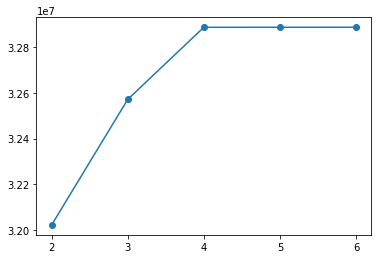

In [8]:
nmf_dict = nmf(V) # N, M, R, moon = 100, 50, 4, 4
plot_nmf(nmf_dict)

For NMF on simulated data, we observe that the log-likelihoodthere clearly increases from R = 3 to 4, then plateaus with no significant increase for R = 5 or 6. This indicates there are 4 gene batteries, consitent with the simulated data. I included R=2 in the NMF model, so that if true R = 3, we can observe the plateau in log-likelihood increase around 3. We don't need to plot beyond R=6 because if LL doesn't plateau by 6, we know R=6 because R in [3,6]. 

Next, we modify the parameters for synthetic data, and oberve that NMF still captures the optimal R (true R=6. The log-likelihood does not plateau from 3-6, indicating 6 gene batteries is optimal based on NMF).

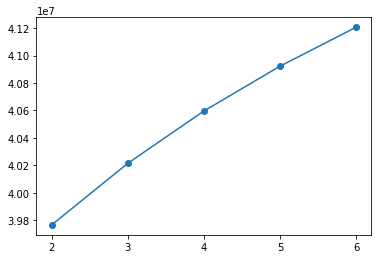

In [9]:
# Modify simulated data parameters N, M, R, and rerun NMF
N2, M2, R2, moon2 = 90, 60, 6, 5
V2, W2, H2 = gen_data(N2, M2, R2, moon2)
nmf_dict2 = nmf(V2)
plot_nmf(nmf_dict2)

In [10]:
best_W1, best_H1 = nmf_dict[4][:2]
best_W2 = nmf_dict2[6][0]

In [11]:
def sort_array_pop(V_array):
    '''Input V_array, sort columns of array based on first element, 2nd element..., return sorted array'''
    n_comp = V_array.shape[0]
    for i in range(n_comp):
        if i == 0:
            pop1= V_array[:,np.argmax(V_array, axis =0) == i]
            pop1_sort = pop1[:,pop1[i].argsort()[::-1]]
        elif i == 1:
            popn = V_array[:,np.argmax(V_array, axis =0) == i]
            popn_sort = popn[:,popn[i].argsort()]
            sorted_array = np.concatenate((pop1_sort,popn_sort), axis =1)
        else:
            popn = V_array[:,np.argmax(V_array, axis =0) == i]
            popn_sort = popn[:,popn[i].argsort()]
            sorted_array = np.concatenate((sorted_array,popn_sort), axis =1)
    
    return sorted_array

In [12]:
# After finding R, sort and row-normalize W, look at histogram
def plot_sorted_array(W):
    '''Input best fit W, sort by row, plot for visualization'''
    fig = plt.figure(figsize=(20,10))
    W_nor = np.divide(W,W.sum(axis=1)[:,None])
    W_sorted = sort_array_pop(W_nor.T).T
    # Make admixture-like bar plot 
    r = np.array(range(W_nor.shape[0]))
    colors = ['r', 'y', 'g', 'b', 'c', 'm', 'k', 'w']
    for a in range(W_sorted.shape[1]):
        plt.bar(r, W_sorted[:,a], bottom = W_sorted[:,:a].sum(axis=1), color=colors[a],alpha=0.7)
    plt.show()
    return W_nor

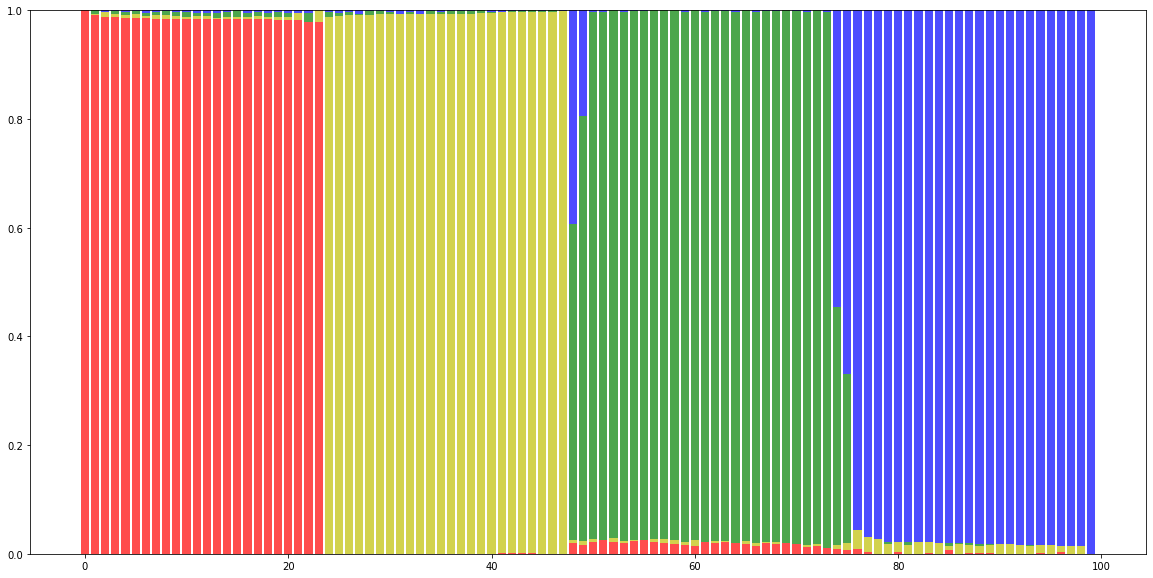

In [13]:
W_nor = plot_sorted_array(best_W1) # We see 4 moonlighting genes

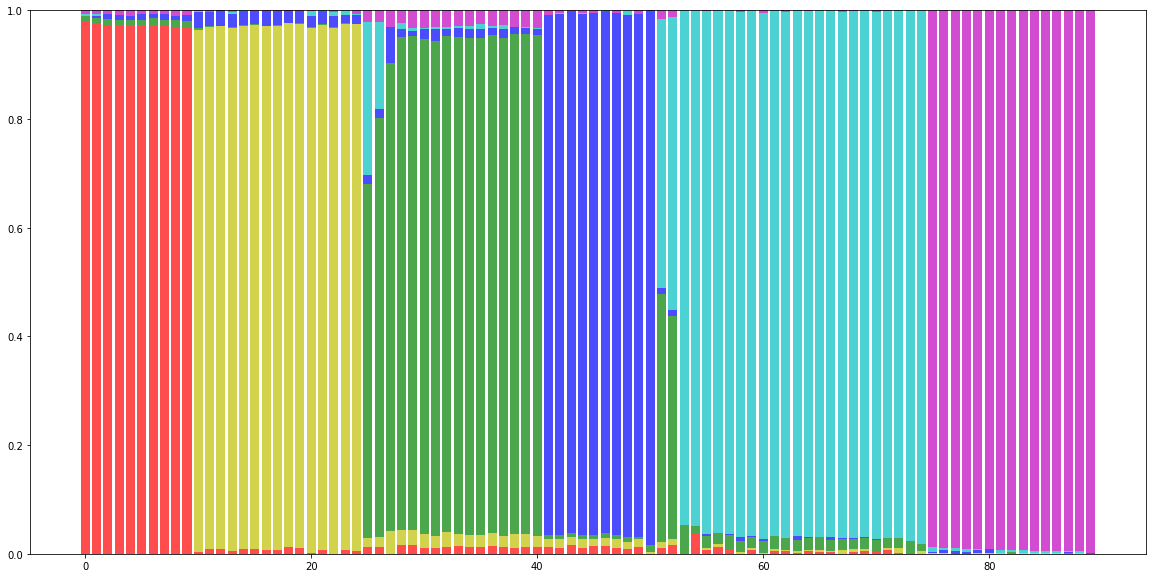

In [14]:
W_nor2 = plot_sorted_array(best_W2) # We see 5 moonlighting genes

Now, let's set a threshold for elements in W, for identification of moonlight genes

In [15]:
def moonlight_genes(W_nor, cutoff=0.1):
    '''Input: W_nor, row-normalized W matrix (not sorted)
    Output: inds, indices correponding to moonlight genes identified by NMF'''
    W_pos = np.sum((W_nor>cutoff), axis=1)
    inds = np.array([i for i in range(len(W_pos)) if W_pos[i]>1])
    return inds

In [16]:
moonlight_genes(W_nor, cutoff=0.1) # Expected 4 moonlight genes

array([13, 35, 68, 97])

In [17]:
moonlight_genes(W_nor2, cutoff=0.1) # Expected 5 moonlight genes

array([29, 71, 76, 80])

In [18]:
# Check if W (ground truth) and W_nor (NMF fit) have the same module sizes
print(np.sum(W>0, axis=0))
print(np.sum(W_nor>0.1, axis=0))

[28 28 24 24]
[24 24 28 28]


In [19]:
print(np.sum(W2>0, axis=0))
print(np.sum(W_nor2>0.1, axis=0))

[18 26 10 15 15 10]
[10 15 18 10 26 15]


In [20]:
# Double check that V was factored correctly
ratio = V/(np.sum(V, axis=0)*np.dot(best_W1,best_H1)) # V/V_exp, where V_exp = C*np.dot(W,H)
ratio

array([[0.99821195, 1.13957141, 0.9834244 , ..., 0.99597206, 1.06022811,
        1.13016384],
       [0.9514663 , 0.98703531, 1.06743138, ..., 1.00484856, 1.04949414,
        0.82289752],
       [0.97902738, 0.94081363, 0.96930796, ..., 1.02370132, 1.04342793,
        0.93852348],
       ...,
       [0.97246274, 0.99841758, 1.03780473, ..., 0.96070851, 1.00585064,
        0.85105488],
       [0.98763406, 1.12168986, 1.05238496, ..., 1.01220496, 1.05028226,
        0.97727745],
       [1.01215615, 0.99989137, 1.00883834, ..., 0.98656877, 1.00590651,
        0.99001005]])

As expected, the ratio between V and $\lambda$ for $\lambda$ calulated using NMF best fit W and H approaches 1 for each element $V_{i\mu}$, indicating accurate factorization and Poisson noise. 

How well does NMF reconstruct the known gene batteries?

NMF reconstructs the known gene batteries well, expecially the number of batteries. In both R=4 and R=6 cases, the NMF model correctly identified the number of gene modules, based on flattening of the log-likelihood curve. Log-likelihood clearly increases for R=a < the true R, but from R>= true R, log-likelihood does not increase significantly. The cluster sizes are similar to expected (in simulated data, each gene was assigned to a cluter using random.choice with uniform probability for each cluster).

However, NMF captures moonlighting genes well but not perfectly. For V (R=4, 4 moonlighting genes), we correctly observed 4 moonlighting genes wit $W_{ia}$ cutoff = 0.1. Module sizes from model fit agreed with ground-truth module sizes in W, indicating correct reconstruction of gene batteries. 

But for synthesized data V2 (R=6, 5 moonlighting genes expected), we could only identify 4 moonlighting genes at cutoff 0.1. Based on # genes in each battery, I conlude that one moonlighting gene was incorrectly identified as belonging to 1 cluster, while other genes were correctly identified based on correct battery sizes (beside one battery smaller than expected by 1). Since best fit W matrix are not sparse (partly due to noise in V), $W_{ia}$ are not exactly 0 for modules gene $i$ doesn't belong to. And cutoff for $W_{ia}$ needs to be set to call whether gene $i$ relates to module $a$; this cutoff may be relatively arbitrary and can require visual inspection of the W admixture plot. 

For synthetic data generation, I made W sparse and did dirichlet along the columns, allowing weights in moonlighting genes to differ widely between 2 modules. NMF can capture most but not all the moonlighting genes. I expect moonlighting genes with significant activity in 2 modules can be accurately detected, but moonlighting genes with relatively small activity in one module compared to another may not be accurately identified. 

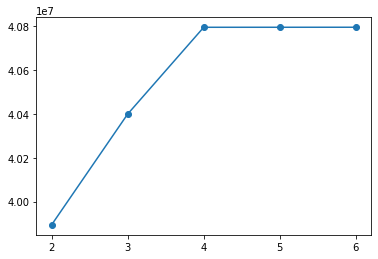

In [21]:
Va = adler_data.to_numpy()
nmf_adler = nmf(Va)
plot_nmf(nmf_adler)

Here we see that LL plateaus after R=4, indicating there are 4 genes batteries. Get W matrix for Adler, plot composition of each gene, and identify the moonlighting genes.

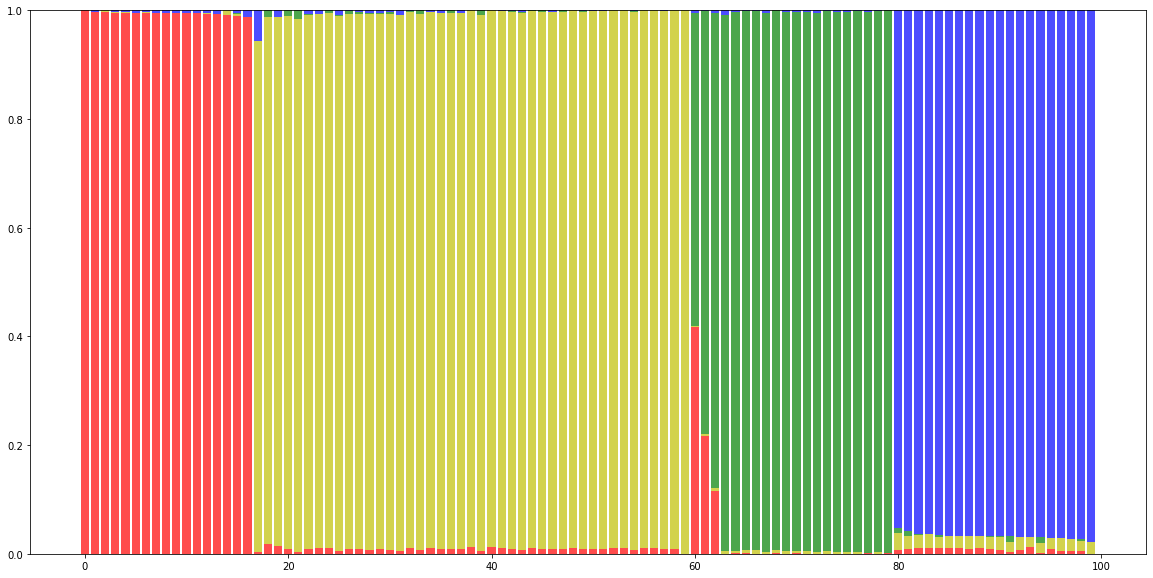

In [22]:
Adler_W = nmf_adler[4][0]
# Plot row sorted, row-normalized W to find moonlight genes
Adler_Wnor = plot_sorted_array(Adler_W)

By visual inspection, there are approximately 3 moonlighting genes (Green and Red). It is possible that not all moonlighting gene were captured (especially moonlighting genes with relatively small weights in one battery and large weights in another). 

In [23]:
moonlight_genes(Adler_Wnor, cutoff=0.05) # cutoff=0.05

array([39, 47, 71, 94])

In [24]:
adler_data.index[94]

'turnip'

Using $W_{ia}$ cutoff = 0.05, NMF identifies 4 moonlighting genes. However, the bar with mostly blue (small green segment) may be a false positive. It is also possible for NMF to produce false negatives, for moonlighting genes with relatively small weights in one module it belongs. Vary cutoff to see how many moonlighting genes would be called. 

In [25]:
inds = moonlight_genes(Adler_Wnor, cutoff=0.03) 
inds

array([39, 47, 71, 80, 94])

In [26]:
inds = moonlight_genes(Adler_Wnor, cutoff=0.1) 
inds

array([39, 47, 71])

I decided to choose cutoff = 0.1, because based on test data in Part 2, decreasing cutoff to < 0.1 increased noise, without recovering false negative genes. 

In [27]:
def classify_genes(W_nor, df, cutoff=0.1):
    '''Classify genes into batteries and dentify moonlighting genes
    Inputs: 
        W_nor - normalized best fit W matrix
        df - dataframe of the data of interest
        cutoff - Wia cutoff
    Outputs: 
        moon_genes: moonlighting gene names
        battery_sizes: a np array of the sizes of each battery
        gene_dict: a dictionary of {module: [gene names]}
    '''
    moon_inds = moonlight_genes(W_nor, cutoff)
    moon_genes = df.index[moon_inds]
    # Assign genes to modules
    battery_sizes = np.sum(W_nor>cutoff, axis=0)
    gene_dict = dict()
    for i in range(W_nor.shape[1]):
        genes = []
        for j in range(W_nor.shape[0]): 
            if W_nor[j,i] > cutoff:
                genes.append(df.index[j])
        gene_dict['Module '+str(i+1)] = genes
    return (moon_genes, battery_sizes, gene_dict)

In [28]:
moonlights, battery_sizes, gene_dict = classify_genes(Adler_Wnor, adler_data)
print('Moonlighting genes: ',str(list(moonlights)))
print('Battery sizes: ', battery_sizes)
print(gene_dict)

Moonlighting genes:  ['grape', 'kohlrabi', 'pepper']
Battery sizes:  [20 43 20 20]
{'Module 1': ['anise', 'cantaloupe', 'chestnut', 'cranberry', 'fig', 'grape', 'kohlrabi', 'leek', 'lentil', 'melon', 'orange', 'papaya', 'parsley', 'pepper', 'plantain', 'pomegranate', 'scallion', 'watermelon', 'yam', 'zucchini'], 'Module 2': ['artichoke', 'arugula', 'avocado', 'banana', 'beet', 'blackberry', 'broccoli', 'caraway', 'cilantro', 'cucumber', 'currant', 'eggplant', 'elderberry', 'ginger', 'gooseberry', 'grapefruit', 'guava', 'honeydew', 'horseradish', 'juniper', 'kiwi', 'lettuce', 'lime', 'maize', 'mustard', 'okra', 'oregano', 'parsnip', 'peach', 'pineapple', 'potato', 'quince', 'raisin', 'rosemary', 'rutabaga', 'sage', 'spinach', 'strawberry', 'thyme', 'tomato', 'turnip', 'wasabi', 'watercress'], 'Module 3': ['apricot', 'asparagus', 'blueberry', 'carrot', 'cauliflower', 'cayenne', 'chickpea', 'clementine', 'coconut', 'coriander', 'endive', 'grape', 'kohlrabi', 'lavender', 'mango', 'onion', 

My best guess for the number of gene batteries is 4, because the log-likelihood of V given V_exp by NMF increases between R=2 and R=4, but plateaus after R=4 with no significant increase between R=4 and R=6. Thus, 4 is the smallest number of batteries that can capture most of the variation in data, so I think there are 4 gene batteries. 

There are [20, 20, 20, 43] genes in each battery. The categorization of gene batteries is given above (Modules 1-4). 

My best guess is there are 3 moonlighting genes ['grape', 'kohlrabi', 'pepper'], all from the same two batteries, using $W_{ia}$ cutoff = 0.1. The 0.1 cutoff is relatively stringent. It is also possible that 'turnip' is a moonlighting gene between 2 different batteries, and it is possible for there to be false negatives. But my best guess is 3 moonlighting genes based on cutoff calculations (see Part 2 reasoning behind cutoffs) and visual inspection of the admixture plot, which show 3 clear moonlighting genes with bars of two colors (belonging to two batteries). 